# Used Packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from keras.models import Sequential 
from keras.models import load_model
from keras.layers import Flatten, Dense, Lambda 
from keras.layers import Conv2D 
from keras.layers.core import Dropout 
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras import optimizers

Using TensorFlow backend.


# Pipeline to identify lane lines

## Compute the Camera Calibration

Not all corners found!
Not all corners found!
Not all corners found!


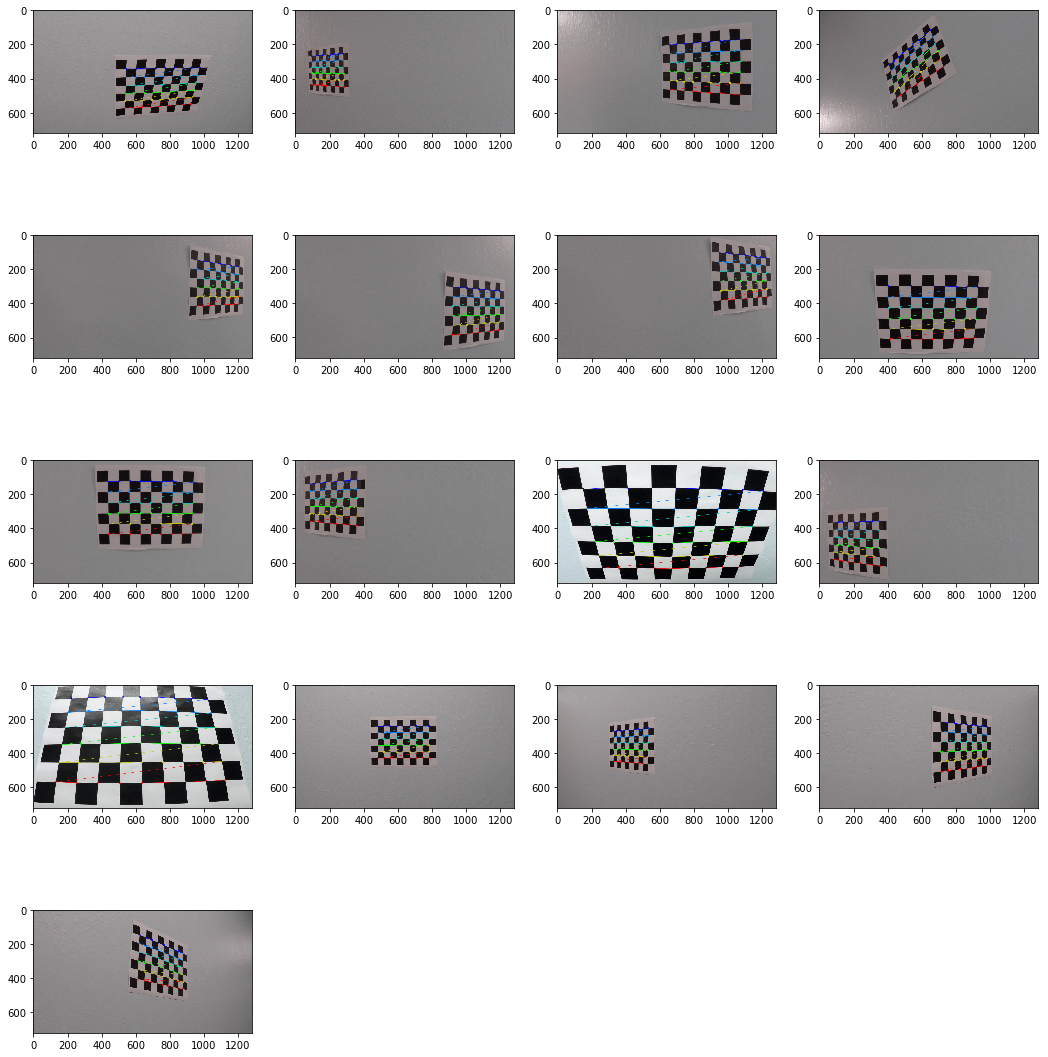

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

plt.figure(1,figsize = (18,20))
plot_counter = 1

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(5,4,plot_counter)
        plt.imshow(img)
        plot_counter += 1
    else:
        print('Not all corners found!')


In [4]:
#Compute Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undist_img(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Define the Projective Transform

In [5]:
#Define the mask
dst = np.float32([[205,720],[1280,0],[0,0],[1075,720]])

delta_x_t = 120
delta_x_b = 575
delta_y = 460

src = np.float32([[640-delta_x_b,720],[640+delta_x_t,delta_y],[640-delta_x_t,delta_y],[640+delta_x_b,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def warp_image(img):
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)

## Define the Lane Finding Pipeline

In [6]:
#This function was provided by udactiy, it is used to identify the lane lines of the first frame of the video

def find_lines_function(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return [left_fit,right_fit]


In [7]:
#Size of the image
x_dim = 1280
y_dim = 720

image_counter = 0

#Width of the corridor which is taken into account around the previous lane line
corr_width = 55

#Tresholds to define which pixel belong to a lane line
bright_th = 190
bright_min_th = 170
sobel_th = 330

#Minimum number of pixels which should be used to fit a line
min_number_try_fit = 40

#Rate on how fast to adapt the lane lines from frame to frame
belive = 0.5

list_coeff_l = []
list_coeff_r = []

#If draw_lane_lines is activate the function prodcues the original video combined with the computed lane lines
#If draw_lane_lines is set to false the function prodcues a video of the input of the fitting procedure
draw_lane_lines = True

#This function defines the pipeline which is used to draw the lane lines on the video 
def pipeline_lane_line(img):
    global image_counter
    global coeff_l
    global coeff_r
    
    #Undistort the image
    img = undist_img(img)
   
    #Combine R and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    R = np.maximum(img[:,:,0],hls[:,:,2])
    
    #Warp the image
    R = warp_image(R)
    
    #If this is the first image of the video:
    #Use the function provided from the course notes to find the initial lines
    if(image_counter == 0):
        #Define binary image for the find_lines_function
        R_bin = np.zeros_like(R)
        sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0,ksize = 5) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        R_bin = ((R >= bright_th)|((abs_sobelx>sobel_th) & (R> bright_min_th ))) 
        
        coeff_l,coeff_r = find_lines_function(R_bin)
    
    image_counter += 1
    
    #Use only points to fit the line which lie inside a corridor of the line from the previous picture
    points_img_left = np.zeros_like(R)
    points_img_right = np.zeros_like(R)
        
    #Define the two corridors around the left and right line from the previous picture    
    ploty = np.linspace(0,y_dim -1, y_dim)
    
    left_fitx = coeff_l[0]*ploty**2 + coeff_l[1]*ploty + coeff_l[2]
    right_fitx = coeff_r[0]*ploty**2 + coeff_r[1]*ploty + coeff_r[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])    
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])    

    pts_int_left = pts_left.astype(int)
    pts_int_right = pts_right.astype(int)

    pts_int_left = pts_int_left[0,:,:]
    pts_int_right = pts_int_right[0,:,:]

    feasible_index_left = ((0<=pts_int_left[:,1]) & (pts_int_left[:,1]<y_dim) & (0<=pts_int_left[:,0]) & (pts_int_left[:,0]<x_dim))
    feasible_index_right = ((0<=pts_int_right[:,1]) & (pts_int_right[:,1]<y_dim) & (0<=pts_int_right[:,0]) & (pts_int_right[:,0]<x_dim))

    image_with_line_left = np.zeros((y_dim,x_dim),dtype = np.int32)
    image_with_line_right = np.zeros((y_dim,x_dim),dtype = np.int32)

    image_with_line_left[pts_int_left[feasible_index_left][:,1],pts_int_left[feasible_index_left][:,0]] = 1
    image_with_line_right[pts_int_right[feasible_index_right][:,1],pts_int_right[feasible_index_right][:,0]] = 1

    image_with_corridor_left = ndimage.maximum_filter(image_with_line_left,corr_width)
    image_with_corridor_right = ndimage.maximum_filter(image_with_line_right,corr_width)

    #Next identify which points may belong to lane lines
    focus_l = R*(image_with_corridor_left==1)
    focus_r = R*(image_with_corridor_right==1)

    sobel_focus_x_l = cv2.Sobel(focus_l, cv2.CV_64F, 1, 0,ksize = 5)
    sobel_focus_x_r = cv2.Sobel(focus_r, cv2.CV_64F, 1, 0,ksize = 5)
    
    abs_sobel_focus_l = np.abs(sobel_focus_x_l)
    abs_sobel_focus_r = np.abs(sobel_focus_x_r)
    
    #We have to take a smaller corridor, since the sobel operator marks the boundaries of the larger corridor
    image_with_corridor_left_smaller = ndimage.maximum_filter(image_with_line_left,corr_width-4)
    image_with_corridor_right_smaller = ndimage.maximum_filter(image_with_line_right,corr_width-4)
    
    #The following rule is used to decide which pixel belongs to a lane line
    candidates_left =  ((image_with_corridor_left==1) & ((R >= bright_th)|((abs_sobel_focus_l>sobel_th) & (image_with_corridor_left_smaller==1) & (R> bright_min_th )))) 
    candidates_right = ((image_with_corridor_right==1) & ((R >= bright_th)|((abs_sobel_focus_r>sobel_th)  & (image_with_corridor_right_smaller==1) & (R> bright_min_th )))) 

    points_img_left[candidates_left] = 1
    points_img_right[candidates_right] = 1

    good_left_inds = points_img_left.nonzero()
    good_right_inds = points_img_right.nonzero()
    
    #At this point we have found the points which may belong to lane lines which were close to the previous lane line
    
    #Try to fit a linear or quadratic function through these points
    #If too few candidate points are found stick with the lane line which was previously found
    score_l = 0
    if(len(good_left_inds[0])>min_number_try_fit):
        try:   
            coeff_l_new_linear,res_linear, _, _, _ = np.polyfit(good_left_inds[0], good_left_inds[1], 1, full = True)
            coeff_l_new, res, _, _, _  = np.polyfit(good_left_inds[0], good_left_inds[1], 2, full = True)
            if(res>0.75*res_linear):
                coeff_l_new = np.array([0,coeff_l_new_linear[0],coeff_l_new_linear[1]])
        except:
            print("Fit error")
            coeff_l_new = coeff_l
    else:
        print('Keep lane')
        coeff_l_new = coeff_l
        
    score_r = 0
    if(len(good_right_inds[0])>min_number_try_fit):
        try:
            coeff_r_new_linear,res_linear, _, _, _ = np.polyfit(good_right_inds[0], good_right_inds[1], 1, full = True)
            coeff_r_new, res, _, _, _  = np.polyfit(good_right_inds[0], good_right_inds[1], 2, full = True)
            if(res>0.75*res_linear):
                coeff_r_new = np.array([0,coeff_r_new_linear[0],coeff_r_new_linear[1]])
        except:
            print("Fit error")
            coeff_r_new = coeff_r
            score_r = 0
    else:
        print('Keep lane')
        coeff_r_new = coeff_r
        score_r = 0
    
    #Update the lane lines
    coeff_l = (1-belive)*coeff_l + belive*coeff_l_new
    coeff_r = (1-belive)*coeff_r + belive*coeff_r_new
       
    #Safe the coefficients of the lane lines
    list_coeff_l.append(coeff_l)
    list_coeff_r.append(coeff_r)
    
    if(draw_lane_lines):
        # Create an image to draw the lane lines
        warp_zero = np.zeros_like(R).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0,y_dim -1, y_dim)
        left_x_final = coeff_l[0]*ploty**2 + coeff_l[1]*ploty + coeff_l[2]
        right_x_final = coeff_r[0]*ploty**2 + coeff_r[1]*ploty + coeff_r[2]

        pts_left = np.array([np.transpose(np.vstack([left_x_final, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x_final, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        
        '''
        #Compute the curvature and the offset
        [curvature_l,curvature_r,offset_real] = compute_curvature_and_offset(coeff_l,coeff_r)
        
        img_to_write = Image.fromarray(result)
        
        draw = ImageDraw.Draw(img_to_write)
        # font = ImageFont.truetype(<font-file>, <font-size>)
        fnt = ImageFont.truetype('OpenSans-Bold.ttf', 30)
        draw.text((50, 50), "Lane Radius:",(255,255,255),font = fnt)
        
        draw.text((260, 50), "Left",(255,255,255),font = fnt)
        draw.text((370, 50), "{:.0f} m".format(curvature_l),(255,255,255),font = fnt)
        
        draw.text((260, 100), "Right",(255,255,255),font = fnt)
        draw.text((370, 100), "{:.0f} m".format(curvature_r),(255,255,255),font = fnt)
        
        draw.text((50, 150),"Offset from center:",(255,255,255), font = fnt)
        draw.text((361, 150),"{:.3f} m".format(offset_real),(255,255,255), font = fnt)
                
        result = np.array(list(img_to_write.getdata()))
        result = result.reshape((y_dim, x_dim,3))
        '''
        return result
    else:
        image_complete_corridor = np.zeros_like(R)
        image_complete_corridor[image_with_corridor_left==1]=1
        image_complete_corridor[image_with_corridor_right==1]=1
        
        empty_frame = np.dstack((np.zeros_like(R),np.zeros_like(R),np.zeros_like(R)))
        empty_frame[:,:,0] = R
        empty_frame[:,:,1] += 255*points_img_left
        empty_frame[:,:,1] += 255*points_img_right
        empty_frame[:,:,2] = 255*image_complete_corridor 
        return empty_frame

# Pipeline to Detect and Track Vehicles

## Training of the Neural Network

### Preparing the Training Data

In [3]:
#Read all file names
kitti_images_name = glob.glob('data/vehicles/KITTI_extracted/*.png')
GTI_far_images_name = glob.glob('data/vehicles/GTI_Far/image*.png')
GTI_left_images_name = glob.glob('data/vehicles/GTI_Left/image*.png')
GTI_middle_images_name = glob.glob('data/vehicles/GTI_MiddleClose/image*.png')
GTI_right_images_name = glob.glob('data/vehicles/GTI_Right/image*.png')

GTI_name = glob.glob('data/non-vehicles/GTI/image*.png')
Extras_name = glob.glob('data/non-vehicles/Extras/extra*.png')


car_names = [kitti_images_name,GTI_far_images_name,GTI_left_images_name,GTI_middle_images_name,GTI_right_images_name]
non_car_names = [GTI_name,Extras_name]

car_images = []
for dataset_names in car_names:
    for name in dataset_names:
        image = mpimg.imread(name)
        car_images.append(image)
        
non_car_images = []
for dataset_names in non_car_names:
    for name in dataset_names:
        image = mpimg.imread(name)
        non_car_images.append(image)

In [6]:
print("Picture with Cars: " + str(len(car_images)))
print("Picture without Cars: " + str(len(non_car_images)))

Picture with Cars: 8792
Picture without Cars: 8968


In [7]:
#Create Training Set Arrays with Labels
car_images = np.array(car_images)
non_car_images = np.array(non_car_images)

#Create Labels
car_labels = np.ones(car_images.shape[0])
non_car_labels = np.zeros(non_car_images.shape[0])

X = np.concatenate((car_images,non_car_images),axis = 0)
y = np.concatenate((car_labels,non_car_labels),axis = 0)

#Free Space
car_images = []
non_car_images =[]


In [8]:
#Shuffle the data set
X,y = shuffle(X,y)

#Save 20% as validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#Free Space
X = 0
y = 0

In [9]:
#Normalize the data set
red_mean = np.mean(X_train[:,:,:,0])
green_mean = np.mean(X_train[:,:,:,1])
blue_mean = np.mean(X_train[:,:,:,2])

mean = np.array([red_mean,green_mean,blue_mean])

X_train[:,:,:,0] = X_train[:,:,:,0] - red_mean
X_train[:,:,:,1] = X_train[:,:,:,1] - green_mean
X_train[:,:,:,2] = X_train[:,:,:,2] - blue_mean

X_val[:,:,:,0] = X_val[:,:,:,0] - red_mean
X_val[:,:,:,1] = X_val[:,:,:,1] - green_mean
X_val[:,:,:,2] = X_val[:,:,:,2] - blue_mean

print(mean)

[ 0.31400156  0.32124332  0.31193045]


### Defining and Training the Neural Network

In [118]:
#Build Convolutional Network (VGG style)
model = Sequential()
model.add(Conv2D(8,(3,3),activation = 'relu',padding = 'same',input_shape=(64,64,3)))
model.add(Conv2D(8,(3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16,(3,3),activation = 'relu',padding = 'same'))
model.add(Conv2D(16,(3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3),activation = 'relu',padding = 'same'))
model.add(Conv2D(32,(14,14),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#And train it
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.6f}.h5',  monitor='val_loss')
adam = optimizers.adam()
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics=['accuracy'])
model.fit(X_train,y_train,batch_size = 128,epochs = 20, callbacks = [checkpointer], validation_data = (X_val,y_val))

## Alternative: Load the Model from Disk

In [8]:
model = load_model('model_car_classification.h5')
mean = np.array([0.31400156,0.32124332,0.31193045])

## Functions used in the Tracking Pipeline

In [9]:
# The sliding window function was created during the Udactiy lectues.
def slide_window(x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = 1280
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = 720
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    #Add boxes at the right boundary
    for ys in range(ny_windows):
        startx = 1152
        endx = 1280
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]

        # Append window position to list
        window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [10]:
# This function gets an image, a list of windows and a trained model
# For each window of the image it computes the predictuion of the trained model
# All predictions are combined in a heat map which is returned by this function

def search_windows_heat(img, windows, NN_clf, mean):
    #Standardize the image
    img = img/255
    img -= mean
    
    #Initialize an empty heat map
    heat_map = np.zeros((720,1280))
    
    #Put all sliding windows at a single batch (so it can be faster processed by the neural network)
    batch_of_windows = np.zeros((len(windows),64,64,3))
    counter = 0
    for window in windows:
        batch_of_windows[counter,:,:,:] = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        counter += 1
    
    #Evaluate the batch with the trained neural network
    batch_prediction = NN_clf.predict(batch_of_windows)
    
    #Add the predictions to the heat map
    counter = 0
    for window in windows:
        heat_map[window[0][1]:window[1][1], window[0][0]:window[1][0]] += batch_prediction[counter]
        counter += 1
    
    return heat_map

In [11]:
# This function takes as input a heat map and produces a list of boxes which mark regions of high intensity
# To find a single box the function take_box_from_heat is called

def find_all_boxes_from_heat(heat_map,start_th,avg_th):
    copy_heat = np.copy(heat_map)    
    box_list = []
    while(True):
        box_found,box = take_box_from_heat(copy_heat,start_th,avg_th)
        
        if(box_found == False):
            break
        
        #Remove heat from region where a box was found
        copy_heat[box[0][1]:box[1][1],box[0][0]:box[1][0]] = 0
        
        #Only add boxes with a minimum area of 1000 pixels
        if((box[1][1]-box[0][1])*(box[1][0]-box[0][0])>1000):
            box_list.append(box)
             
    return box_list

# This function takes as input a heat map and produces a single box which marks a region of high intensity

def take_box_from_heat(heat_map,start_th,avg_th):
    
    # If the highest intensity is to low return no box
    if(np.max(heat_map)<=start_th):
        return False, ((0,0),(0,0))
    
    # Take the pixel with the highest intensity as the middle point of the box
    midpoint = np.unravel_index(np.argmax(heat_map),heat_map.shape)
    
    stepsize = 10
    step_size = 10
        
    # Coordinates of the starting box
    y_1 = midpoint[0]-stepsize
    x_1 = midpoint[1]-stepsize
    
    y_2 = midpoint[0]+stepsize
    x_2 = midpoint[1]+stepsize
    
    # Grow the starting box until the average intensity in the box is to small
    while(True):
        
        # Consider all 4 directions in which a box can be enlarged (top,bottom,left,right)
        if(y_1 == 0):
            up_value = -1
        else:            
            up_value = np.average(heat_map[np.maximum(0,y_1-stepsize):y_1,x_1:x_2])
            
        if(y_2 == heat_map.shape[0]):
            bot_value = -1
        else:            
            bot_value = np.average(heat_map[y_2:np.minimum(heat_map.shape[0],y_2+stepsize),x_1:x_2])
        
        if(x_1 == 0):
            left_value = -1
        else:            
            left_value = np.average(heat_map[y_1:y_2,np.maximum(0,x_1-step_size):x_1])
            
        if(x_2 == heat_map.shape[1]):
            right_value = -1
        else:            
            right_value = np.average(heat_map[y_1:y_2,x_2:np.minimum(heat_map.shape[1],x_2+step_size)])
        
        values = np.array([up_value,bot_value,left_value,right_value])
        
        best_choice = np.argmax(values)
        
        if(best_choice == 0):
            y_1 = np.maximum(0,y_1 - step_size)
        if(best_choice == 1):
            y_2 = np.minimum(heat_map.shape[0], y_2 + step_size)
        if(best_choice == 2):
            x_1 = np.maximum(0,x_1 - step_size)
        if(best_choice == 3):
            x_2 = np.minimum(heat_map.shape[1], x_2 + step_size)
        
        small_box = heat_map[y_1:y_2,x_1:x_2]
        if(np.average(small_box)< avg_th):
            break
    
    box = ((x_1,y_1),(x_2,y_2))
    
    return True, box


In [12]:
# Function to draw boxes on an image

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [13]:
# Function which computes the distance between a box and a car object
def car_box_distance(car,box_2):
    box_1 = car.box
    return np.sqrt((box_1[0][0]-box_2[0][0])**2+(box_1[0][1]-box_2[0][1])**2) + np.sqrt((box_1[1][0]-box_2[1][0])**2+(box_1[1][1]-box_2[1][1])**2)

#Thresholding parameters specifing the car class
box_distance_th = 300
believe_th = 0.05
believe_th_high = 0.5

# The car class is used to track cars during the video
class Car:
    def __init__(self,box):
        self.box = box
        self.believe = 0.05
    
    def decrease_believe(self):
        self.believe = 0.975*self.believe
    
    def update_box(self,box):
        avg_box = ((int(0.9*self.box[0][0] +0.1*box[0][0]),int(0.9*self.box[0][1] +0.1*box[0][1])),(int(0.9*self.box[1][0] +0.1*box[1][0]),int(0.9*self.box[1][1] +0.1*box[1][1])))
        self.box = avg_box
        self.believe = 0.95*self.believe + 0.05
        
# This function updates all existing cars using the informations of the new found boxes
def update_all_cars(list_of_cars,list_of_boxes):
    
    car_updated = {}
    
    for car in list_of_cars:
        car_updated[car] = False
    
    for box in list_of_boxes:
        corresponding_car_found = False
        
        for car in list_of_cars:
            if(car_box_distance(car,box) < box_distance_th):
                car.update_box(box)
                corresponding_car_found = True
                car_updated[car] = True
                break
        if(corresponding_car_found == False):
            new_car = Car(box)
            car_updated[new_car] = True
            list_of_cars.append(new_car)
    
    for car in list_of_cars:
        if(car_updated[car] == False):
            car.decrease_believe()
    
    #Remove cars from list if belive is too small
    for car in list_of_cars:
        if(car.believe < believe_th):
            list_of_cars.remove(car)

# This function returns boxes only with an belive above the threshold
def return_all_believed_car_boxes(list_of_cars):
    list_of_boxes = []
    for car in list_of_cars:
        if(car.believe > believe_th_high):
            list_of_boxes.append(car.box)
    return list_of_boxes

In [14]:
windows = slide_window(x_start_stop=[None, None], y_start_stop=[360,700], xy_window=[128,64], xy_overlap=(0.6,0.6))

heat_saved = np.zeros((720,1280))
list_of_cars = []

# The complete pipeline to draw lane lines and to track and detect vehicles
def complete_pipeline(image,mean = mean,model = model):
    global heat_saved
    global list_of_cars
    
    #Use the lane line pipeline to draw the lane lines onto the frame
    image_with_lane_line = pipeline_lane_line(image)
    image_with_lane_line = np.array(image_with_lane_line,dtype = 'uint8')
    
    # Compute the heat map of the actual frame
    heat_map = search_windows_heat(image, windows, model, mean)                       
    
    #Convert heat map to 0-255
    heat_map *=31.875 #*255/8 
    
    #Blur the heat map
    heat_map = cv2.GaussianBlur(heat_map,(65,65),0)
    
    #Average the heat map with the previous heat map
    heat_saved = 0.8*heat_saved+0.2*heat_map
    
    #Find all boxes from the heat map
    boxes = find_all_boxes_from_heat(heat_saved,70,55)
   
    #Use the boxes to update the believe of the existing cars or to create new cars
    update_all_cars(list_of_cars,boxes)

    #Draw only the cars which have a high enough believe 
    boxes_to_draw = return_all_believed_car_boxes(list_of_cars)
    
    #Create the final result by drawing the boxes onto the image with the lane lines
    result = draw_boxes(image_with_lane_line,boxes_to_draw)
        
    return result

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Initialize Variables for Pipeline
heat_saved =np.zeros((720,1280))
list_of_cars = []
image_counter = 0
list_coeff_l = []
list_coeff_r = []

lane_output = 'test_solution.mp4'
#lane_output = 'project_solution.mp4'

clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")

lane_clip = clip1.fl_image(complete_pipeline) 

%time lane_clip.write_videofile(lane_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_solution.mp4
[MoviePy] Writing video test_solution.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:16<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_solution.mp4 

Wall time: 17.6 s
